In [1]:
import hepmc
import numpy as np
import matplotlib.pyplot as plt
import plotting

# Physics Setting
Process is defined by probability amplitude $f \propto \mathcal{\left|M\right|^2}$. 

Total cross section of a process:
$$\sigma = \int{\text{d}x \, f(x)}.$$

Expectation value of some observable $\mathcal{O}$:
$$\langle\mathcal{O}\rangle = \frac{\int{\text{d}x \, \mathcal{O}(x) f(x)} }{\int{\text{d}x \, f(x)} }.$$

Given $f$ (i.e. the matrix element $\mathcal{M}$), the numerical problem is to
1. Compute the total cross section $\sigma$,
2. Provide (phase space) samples (i.e. events) distributed according to $f$.

For $n$ particles have $3n - 4$ dimensional phase space, which makes scaling in the dimensionality
crucial. Therefore use
1. Monte Carlo integration,
2. Markov chains (based on Metropolis-Hasting).


### Data flow

$$ \text{(Perturbative) Hard matrix element } \mathcal{M} $$
$$\downarrow$$
$$ \textbf{1. Monte Carlo} $$
$$\downarrow$$
$$ \text{Cross section } \sigma \text{, events } p_i $$
$$\downarrow$$
$$ \textbf{2. Parton showering} $$
$$\downarrow$$
$$ \text{Propagated events} $$
$$\downarrow$$
$$ \textbf{3. Hadronization} $$
$$\downarrow$$
$$ \text{Observable events} $$
$$\downarrow$$
$$ \textbf{detector simulation} $$
$$\downarrow$$
$$ \text{Final data} $$


# Integration
Use (multi-channel) importance sampling Monte Carlo integration to get $\sigma$.

# Metropolis Sampling, Markov Chain

## Quality measure
- bin-wise $\chi^2$ and p-value testing compatibility with target
- should replace experimental events $\rightarrow$ low autocorrelation
- effective sample size

## Hamiltonian Monte Carlo
For target pdf $f$, define potential $$V(x) = - \log{f(x)}.$$ Artificial Gaussian distributed momentum $p$, $$K(p) = p^T M^{-1} p.$$
Total Hamiltonian for system $$H(x, p) = V(x) + K(p)$$ such that total probability $$p(x, p) = e^{-H(x, p)}.$$

For dynamics use leapfrog algorithm, need gradient of $V(x)$.

### Camel distribution

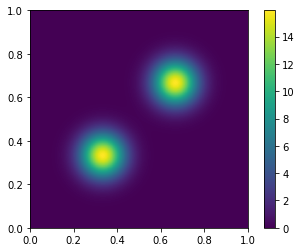

In [12]:
camel = hepmc.densities.Camel(2)

x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000) 
mgrid = np.meshgrid(x, y)
plt.imshow(camel(*mgrid), extent=(0, 1, 0, 1), origin='lower')
plt.colorbar()
plt.show()

### HMC trajectory on Camel distribution

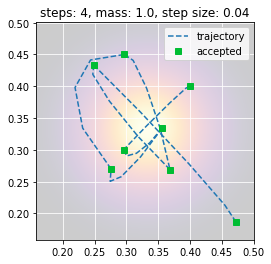

In [2]:
target = hepmc.densities.Camel(2)  # gradient is known

plotting.plot_hmc_traj(target, 7, mass=1., steps=4, step_size=.04)

Generated 200 samples.
Generated 400 samples.
Generated 600 samples.
Generated 800 samples.
Generated 1000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.57002386 0.57049835],[0.02726167 0.02705757],"8.203, p=1.234e-24, N=21",[14.93217091 14.97780472],0.997000


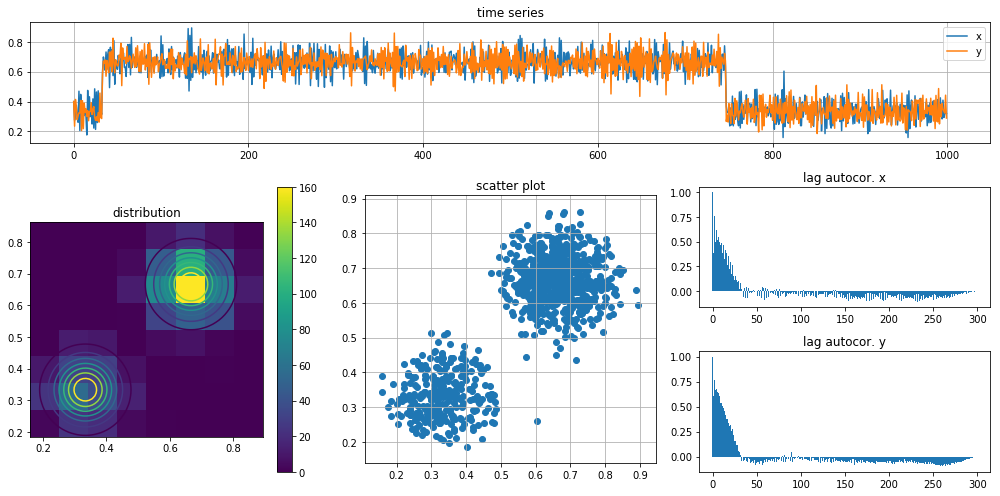

In [14]:
target = hepmc.densities.Camel(2)
mass = 1.
steps = 20
step_size = .008
count = 1000

sampler, start = hepmc.interfaces.plain_hmc.get_sampler(target, 2, .4, mass=mass, steps=steps, step_size=step_size)
sampler.sample(count, start, log_every=count/5)

### HMC on single Gaussian

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.49920274 0.49726559],[0.01036438 0.00989417],"0.9935, p=0.4771, N=33",[1000. 1000.],0.976000


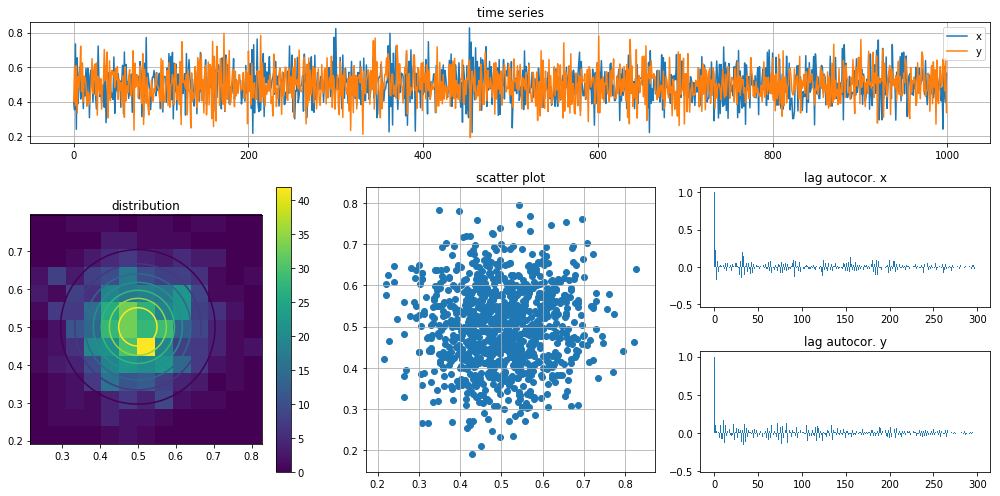

In [13]:
target = hepmc.densities.Gaussian(2, mu=0.5, scale=0.1)
mass = 1.
steps = 4
step_size = .05
count = 1000

sampler, start = hepmc.interfaces.plain_hmc.get_sampler(target, 2, .4, mass=mass, steps=steps, step_size=step_size)
sampler.sample(1000, start)

plotting 3


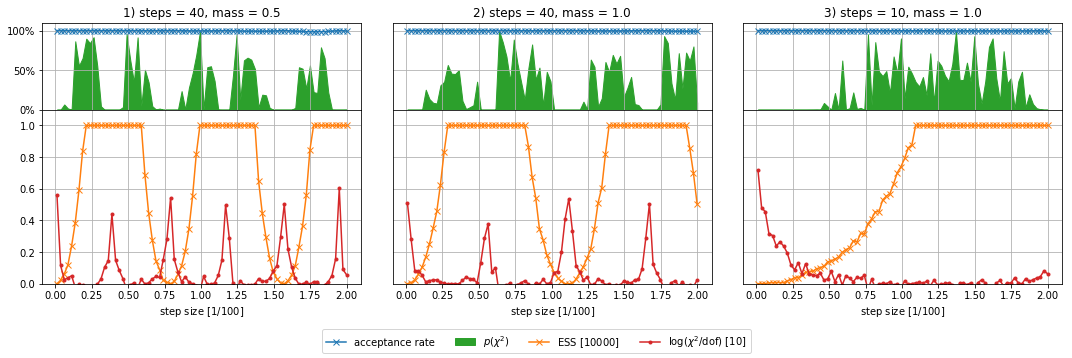

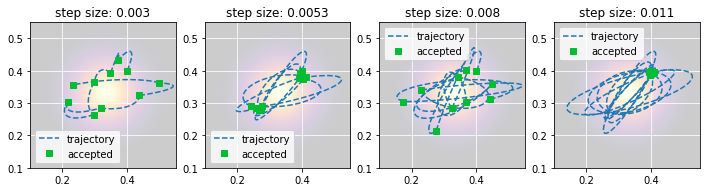

In [18]:
plt.figure(figsize=(15, 5))
runs = plotting.load_from_config(['gauss_overview.json'], base='../samples_analysis/gauss/')
plotting.plot_all_fancy('step_size', np.array(runs)[[5, 6, 2]], 3, 10, 10000, bottom=.2)
plt.show()

plt.figure(figsize=(12, 4))

index = 141

for sz in [.003, .0053, .008, .011]:
    np.random.seed(42)
    plt.subplot(index)
    index += 1
    plotting.plot_hmc_traj(target, mass=1., steps=40, step_size=sz, count=9, extent=[[0.1, 0.55], [0.1, 0.55]])
    plt.title('step size: %s'%sz)

# MC$^3$
Mixing Markov update, switch between

1. Metropolis Hasting update using the multi-channel of the integration as proposal
2. Local Markov chain (local Gaussian, HMC, ...)

The importance sampling update is chosen with probability $\beta$.

## MC$^3$ with local Gaussian proposal

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.48682116 0.48220788],[0.03140914 0.03040039],"5.77, p=2.006e-13, N=18",[457.24387482 498.90043027],0.876000


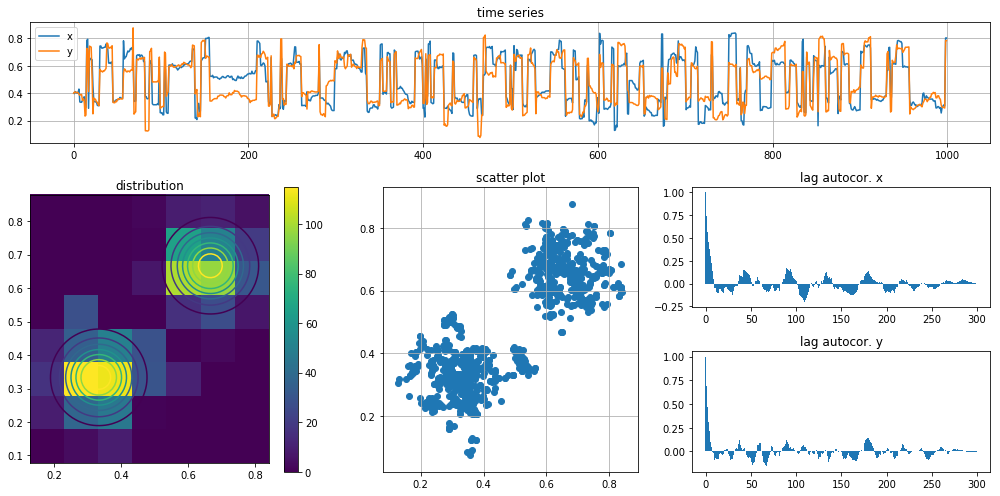

In [22]:
target = hepmc.densities.Camel(2)
# mc3
beta = .3
local_size = 0.01
count = 1000

# importance channel
w = np.sqrt(.1**2/2)
centers=[[1/3*.9, 1/3*.9], [2/3, 2/3]]
widths=[w, w*1.1]

sampler, start = hepmc.interfaces.mc3_gauss.get_sampler(target, 2, initial=.4, 
                                                        centers=centers, widths=widths, local_width=local_size, beta=beta)
sampler.sample(count, start)

# MC$^3$ with HMC

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.49869525 0.50236123],[0.03237161 0.03445699],"2.121, p=0.01038, N=14",[600.64257284 541.53506191],0.903000


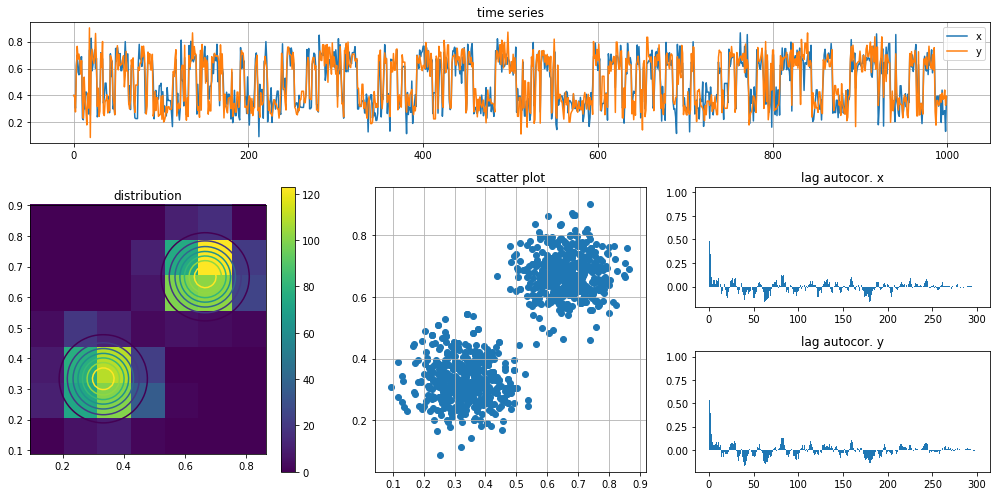

In [32]:
target = hepmc.densities.Camel(2)
# mc3
beta = .4
local_size = 0.01
count = 1000

# HMC
mass = 1.
steps = 40
step_size = .008
count = 1000

# importance channel
w = np.sqrt(.1**2/2)
centers=[[1/3*.9, 1/3*.9], [2/3, 2/3]]
widths=[w, w*1.1]

sampler, start = hepmc.interfaces.mc3_hmc.get_sampler(target, 2, initial=.4, 
                                                      mass=mass, steps=steps, step_size=step_size,
                                                      centers=centers, widths=widths, beta=beta)
sampler.sample(count, start, log_every=count/4)

# Real Example
Process $e^+ e^- \rightarrow q \bar{q}$

In [83]:
e_cm = 100.
mapping = hepmc.phase_space.RamboOnDiet(e_cm, 2)
target = hepmc.phase_space.MappedDensity(hepmc.densities.ee_qq(e_cm), mapping)

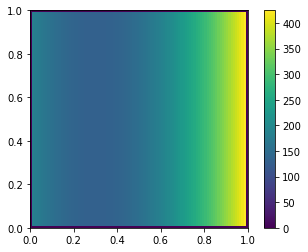

In [84]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)
prob = target(*mgrid)
plt.imshow(prob, origin='lower', extent=((0, 1, 0, 1)))
plt.colorbar()

### Learn surrogate of potential

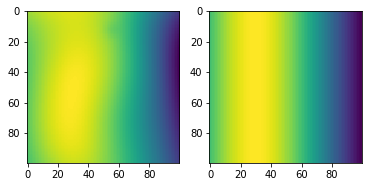

In [50]:
nodes = 10
nlearn = 1000
x = np.linspace(0.001, .999, 100)
y = np.linspace(0.001, .999, 100)
mgrid = np.meshgrid(x, y)

xvals = np.random.random((nlearn, 2))
fvals = target.pdf(xvals)

# surrogate
basis = hepmc.surrogate.extreme_learning.GaussianBasis(2)
log_vals = -np.ma.log(fvals)
xvals = xvals[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]
# train
params = basis.extreme_learning_train(xvals, log_vals, nodes)

# surrogate gradient
def surrogate_gradient(xs):
    return basis.eval_gradient(*params, xs)
target.pot_gradient = surrogate_gradient

plt.subplot(121)
plt.imshow(basis.eval_split(*params, *mgrid))
plt.subplot(122)
plt.imshow(-np.log(target(*mgrid)))
plt.show()

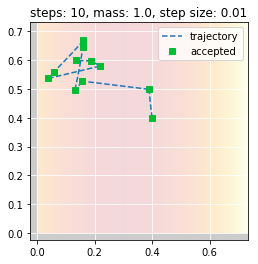

In [67]:
plotting.plot_hmc_traj(target, mass=1., steps=10, step_size=.01)

0.000000 * 0.479686 = 0.000000 ; 0.866859 > 0.000000
0.000000 * 0.678538 = 0.000000 ; 0.990063 > 0.000000
0.000000 * 0.842829 = 0.000000 ; 0.881644 > 0.000000
0.000000 * 0.599940 = 0.000000 ; 0.842953 > 0.000000


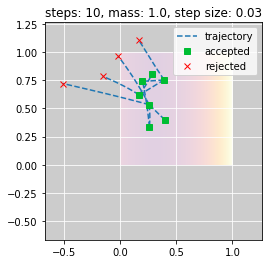

In [68]:
plotting.plot_hmc_traj(target, mass=1., steps=10, step_size=.03)

# Spherical HMC

In [75]:
# have to normalize target
int_sample = hepmc.PlainMC(2)(target, 50000)
int_sample.integral, int_sample.integral_err

target.norm = int_sample.integral

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.65755412 0.48654736],[0.08511249 0.08356793],"3.702, p=1.804e-12, N=35",None,0.979000


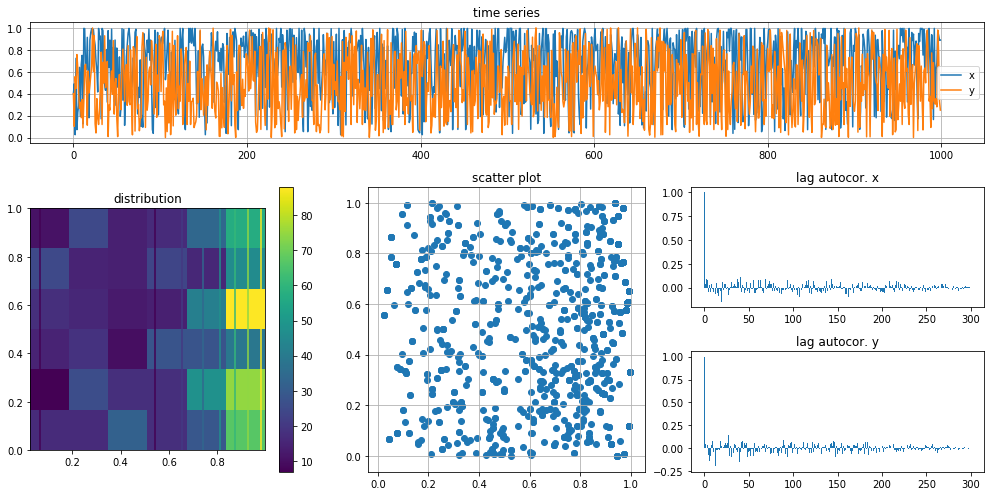

In [76]:
sampler = hepmc.hamiltonian.StaticSphericalHMC(target, .03, .03, 30, 30)
sampler.sample(1000, start)